# **Cancel Culture - Classification Modeling Notebook**

---

**Post-Cleaning Modeling Notebook**

---

# -- > 🛑 **FIX**: Add cmts re: post-cleaning, modeling

---

>

---

# **Imports**

---

> I will import several packages and modules to perform my modeling steps. I use different parts of Scikit-Learn's numerous packages for the majority of my modeling. In addition to SKLearn, I tested models from XGBoost as well as Imblearn towards the end of the modeling process.
>
> I include the usual packages as well: pandas, numpy, matplotlib, and seaborn. Additionally, I have several personal functions that I use during the modeling process.

---

In [1]:
## Jupyter Notebook setting to reload functions when called
%load_ext autoreload
%autoreload 2

In [2]:
## Data Handling
import pandas as pd
import numpy as np

## Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

## Personal functions
from bmc_functions import classification as clf

## SKLearn and Modeling Tools
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import ExtraTreesClassifier, AdaBoostClassifier,\
                             GradientBoostingClassifier 
from sklearn import set_config
set_config(display='diagram')

# from xgboost import XGBClassifier

# from imblearn.over_sampling import SMOTENC
from imblearn.ensemble import BalancedBaggingClassifier,\
                                BalancedRandomForestClassifier,\
                                EasyEnsembleClassifier, RUSBoostClassifier

In [25]:
## Settings
%matplotlib inline
sns.set_context("notebook", font_scale=1.25)
pd.set_option('display.max_columns', 150)
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
pd.set_option('max_rows', 50)

# **Reading the DataFrames**

---

> In my prior EDA notebook, I reviewed, cleaned, and performed some pre-processing steps to prepare my data separately before modeling. I saved the data as a .pickle file to preserve the datatypes; now I will re-read the data for modeling purposes.

---

In [4]:
data = pd.read_pickle('./data/data_prepped.pickle',
                           compression = 'gzip')
data.head(5)

,hotel,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,assigned_room_type,booking_changes,deposit_type,agent,days_in_waiting_list,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,arrival_date,arrival_day
0,Resort Hotel,0,342,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,3,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
1,Resort Hotel,0,737,2015,July,27,1,0,0,2,0.00,0,BB,PRT,Direct,Direct,0,0,0,C,C,4,No Deposit,999,0,Transient,0.00,0,0,Check-Out,2015-07-01,2015-07-01,Wednesday
2,Resort Hotel,0,7,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Direct,Direct,0,0,0,A,C,0,No Deposit,999,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
3,Resort Hotel,0,13,2015,July,27,1,0,1,1,0.00,0,BB,GBR,Corporate,Corporate,0,0,0,A,A,0,No Deposit,304,0,Transient,75.00,0,0,Check-Out,2015-07-02,2015-07-01,Wednesday
4,Resort Hotel,0,14,2015,July,27,1,0,2,2,0.00,0,BB,GBR,Online TA,TA/TO,0,0,0,A,A,0,No Deposit,240,0,Transient,98.00,0,1,Check-Out,2015-07-03,2015-07-01,Wednesday


# **Train/Test Split**

In [5]:
## Identifying target
target= 'is_canceled'

In [6]:
## Dropping target and "reservation_status" (nearly identical indicator)

X = data.drop(columns = [target, 'reservation_status']).copy()
y = data[target].copy()

In [7]:
## Checking for missing values
print(f'Missing values for X:\n {X.isna().sum()[X.isna().sum() >0]}\n')
print(f'Missing values for y: {y.isna().sum()}')

Missing values for X:
 Series([], dtype: int64)

Missing values for y: 0


In [8]:
## Splitting - stratify to maintain class balance b/t X_train/_test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, 
                                                    random_state=42, 
                                                    stratify=y)

In [9]:
## Saving memory by deleting unused X, y
del X, y

In [10]:
## Specifying numeric columns for preprocessing
num_cols = X_train.select_dtypes('number').columns.to_list()
num_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests']

In [11]:
## Specifying numeric columns for preprocessing
cat_cols = X_train.select_dtypes(include='object').columns.to_list()
cat_cols

['hotel',
 'arrival_date_year',
 'arrival_date_month',
 'arrival_date_week_number',
 'arrival_date_day_of_month',
 'meal',
 'country',
 'market_segment',
 'distribution_channel',
 'reserved_room_type',
 'assigned_room_type',
 'deposit_type',
 'agent',
 'customer_type',
 'arrival_day']

# **Prepping the Pipeline**

---

> Pipeline to streamline modeling steps:
* Preprocessing: OHE, scaling, outliers via ƒ-XF?
* Modeling: RFC, BRFC
* GSCV: include as part of pipeline
* Get results:
    * Feature importances - **SHAP**

---

In [12]:
## Creating ColumnTransformer and sub-transformers for imputation and encoding

### --- Creating column pipelines --- ###

cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore',
                                                 sparse=False))])

num_pipe = Pipeline(steps=[('scaler', StandardScaler())])

## Instantiating the ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[('num', num_pipe, num_cols),
                  ('cat', cat_pipe, cat_cols)
                  ])

preprocessor

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['lead_time', 'stays_in_weekend_nights',
                                  'stays_in_week_nights', 'adults', 'children',
                                  'babies', 'is_repeated_guest',
                                  'previous_cancellations',
                                  'previous_bookings_not_canceled',
                                  'booking_changes', 'days_in_waiting_list',
                                  'adr', 'required_car_parking_spaces',
                                  'total_of_special_r...s']),
                                ('cat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['hotel', 'arrival_date_year',
                                  'arrival_date_month',
                                  'arrival_date_week_number',
                                  'arrival_date_day_of_month', 'meal',
                                  'country', 'market_segment',
                                  'distribution_channel', 'reserved_room_type',
                                  'assigned_room_type', 'deposit_type', 'agent',
                                  'customer_type', 'arrival_day'])])

In [13]:
## Fitting feature preprocessor
preprocessor.fit(X_train)

## Getting feature names from OHE
ohe_cat_names = preprocessor.named_transformers_['cat'].named_steps['ohe'].get_feature_names(cat_cols)

## Generating list for column index
final_cols = [*num_cols, *ohe_cat_names]

final_cols

['lead_time',
 'stays_in_weekend_nights',
 'stays_in_week_nights',
 'adults',
 'children',
 'babies',
 'is_repeated_guest',
 'previous_cancellations',
 'previous_bookings_not_canceled',
 'booking_changes',
 'days_in_waiting_list',
 'adr',
 'required_car_parking_spaces',
 'total_of_special_requests',
 'hotel_City Hotel',
 'hotel_Resort Hotel',
 'arrival_date_year_2015',
 'arrival_date_year_2016',
 'arrival_date_year_2017',
 'arrival_date_month_April',
 'arrival_date_month_August',
 'arrival_date_month_December',
 'arrival_date_month_February',
 'arrival_date_month_January',
 'arrival_date_month_July',
 'arrival_date_month_June',
 'arrival_date_month_March',
 'arrival_date_month_May',
 'arrival_date_month_November',
 'arrival_date_month_October',
 'arrival_date_month_September',
 'arrival_date_week_number_1',
 'arrival_date_week_number_10',
 'arrival_date_week_number_11',
 'arrival_date_week_number_12',
 'arrival_date_week_number_13',
 'arrival_date_week_number_14',
 'arrival_date_week_n

In [14]:
## Transform the data via the ColumnTransformer preprocessor

X_train_tf = preprocessor.transform(X_train)
X_train_tf_df = pd.DataFrame(X_train_tf, columns=final_cols, index=X_train.index)

X_test_tf = preprocessor.transform(X_test)
X_test_tf_df = pd.DataFrame(X_test_tf, columns=final_cols, index=X_test.index)

display(X_train_tf_df.head(5),X_test_tf_df.head(5))

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_week_number_1,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_2,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_3,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_week_number_36,arrival_date_week_number_37,arrival_date_week_number_38,arrival_date_week_number_39,arrival_date_week_number_4,arrival_date_week_number_40,arrival_date_week_number_41,arrival_date_week_number_42,arrival_date_week_number_43,arrival_date_week_number_44,arrival_date_week_number_45,arrival_date_week_number_46,arrival_date_week_number_47,arrival_date_week_number_48,arrival_date_week_number_49,...,agent_476,agent_479,agent_481,agent_483,agent_484,agent_492,agent_493,agent_495,agent_497,agent_5,agent_50,agent_502,agent_508,agent_509,agent_510,agent_52,agent_526,agent_527,agent_53,agent_531,agent_535,agent_55,agent_56,agent_57,agent_58,agent_59,agent_6,agent_60,agent_61,agent_63,agent_64,agent_66,agent_67,agent_68,agent_69,agent_7,agent_70,agent_71,agent_72,agent_74,agent_75,agent_77,agent_78,agent_79,agent_8,agent_81,agent_82,agent_83,agent_85,agent_86,agent_87,agent_88,agent_89,agent_9,agent_90,agent_91,agent_92,agent_93,agent_94,agent_95,agent_96,agent_98,agent_99,agent_999,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_day_Friday,arrival_day_Monday,arrival_day_Saturday,arrival_day_Sunday,arrival_day_Thursday,arrival_day_Tuesday,arrival_day_Wednesday
67110,0.52,0.07,-0.26,0.24,-0.26,-0.08,-0.18,-0.10,-0.09,-0.33,-0.13,0.56,-0.25,-0.72,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00
95128,0.42,0.07,-0.26,0.24,4.77,-0.08,-0.18,-0.10,-0.09,-0.33,-0.13,1.83,3.85,0.54,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00

,lead_time,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,adr,required_car_parking_spaces,total_of_special_requests,hotel_City Hotel,hotel_Resort Hotel,arrival_date_year_2015,arrival_date_year_2016,arrival_date_year_2017,arrival_date_month_April,arrival_date_month_August,arrival_date_month_December,arrival_date_month_February,arrival_date_month_January,arrival_date_month_July,arrival_date_month_June,arrival_date_month_March,arrival_date_month_May,arrival_date_month_November,arrival_date_month_October,arrival_date_month_September,arrival_date_week_number_1,arrival_date_week_number_10,arrival_date_week_number_11,arrival_date_week_number_12,arrival_date_week_number_13,arrival_date_week_number_14,arrival_date_week_number_15,arrival_date_week_number_16,arrival_date_week_number_17,arrival_date_week_number_18,arrival_date_week_number_19,arrival_date_week_number_2,arrival_date_week_number_20,arrival_date_week_number_21,arrival_date_week_number_22,arrival_date_week_number_23,arrival_date_week_number_24,arrival_date_week_number_25,arrival_date_week_number_26,arrival_date_week_number_27,arrival_date_week_number_28,arrival_date_week_number_29,arrival_date_week_number_3,arrival_date_week_number_30,arrival_date_week_number_31,arrival_date_week_number_32,arrival_date_week_number_33,arrival_date_week_number_34,arrival_date_week_number_35,arrival_date_week_number_36,arrival_date_week_number_37,arrival_date_week_number_38,arrival_date_week_number_39,arrival_date_week_number_4,arrival_date_week_number_40,arrival_date_week_number_41,arrival_date_week_number_42,arrival_date_week_number_43,arrival_date_week_number_44,arrival_date_week_number_45,arrival_date_week_number_46,arrival_date_week_number_47,arrival_date_week_number_48,arrival_date_week_number_49,...,agent_476,agent_479,agent_481,agent_483,agent_484,agent_492,agent_493,agent_495,agent_497,agent_5,agent_50,agent_502,agent_508,agent_509,agent_510,agent_52,agent_526,agent_527,agent_53,agent_531,agent_535,agent_55,agent_56,agent_57,agent_58,agent_59,agent_6,agent_60,agent_61,agent_63,agent_64,agent_66,agent_67,agent_68,agent_69,agent_7,agent_70,agent_71,agent_72,agent_74,agent_75,agent_77,agent_78,agent_79,agent_8,agent_81,agent_82,agent_83,agent_85,agent_86,agent_87,agent_88,agent_89,agent_9,agent_90,agent_91,agent_92,agent_93,agent_94,agent_95,agent_96,agent_98,agent_99,agent_999,customer_type_Contract,customer_type_Group,customer_type_Transient,customer_type_Transient-Party,arrival_day_Friday,arrival_day_Monday,arrival_day_Saturday,arrival_day_Sunday,arrival_day_Thursday,arrival_day_Tuesday,arrival_day_Wednesday
34262,-0.50,0.07,0.79,0.24,-0.26,-0.08,-0.18,-0.10,-0.09,1.18,-0.13,-0.62,-0.25,0.54,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
78954,-0.94,-0.93,-0.78,-1.45,-0.26,-0.08,5.55,-0.10,4.57,-0.33,-0.13,-0.70,-0.25,-0.72,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,

# **--->** 🛑 Add Comment: Class Imbalance

---

> Due to class imbalance, will attempt to use "class_weight = balanced" to correct.

---

# **Baseline Model**


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced accuracy score: 0.5
Testing balanced accuracy score: 0.51
	- The training score is smaller by 0.01 points.

Training data log loss: 16.06
Testing data log loss: 15.89



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.63      0.64      0.64     18792
           1       0.38      0.38      0.38     11056

    accuracy                           0.54     29848
   macro avg       0.51      0.51      0.51     29848
weighted avg       0.54      0.54      0.54     29848



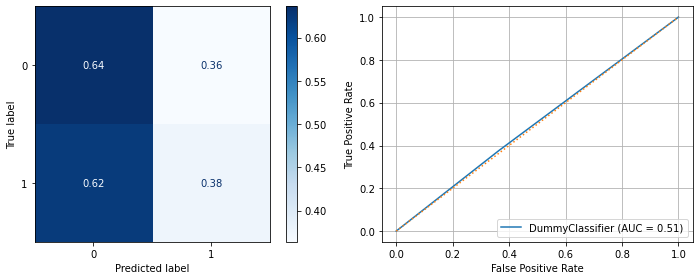


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.63      0.63      0.63     56374
           1       0.37      0.37      0.37     33168

    accuracy                           0.53     89542
   macro avg       0.50      0.50      0.50     89542
weighted avg       0.53      0.53      0.53     89542



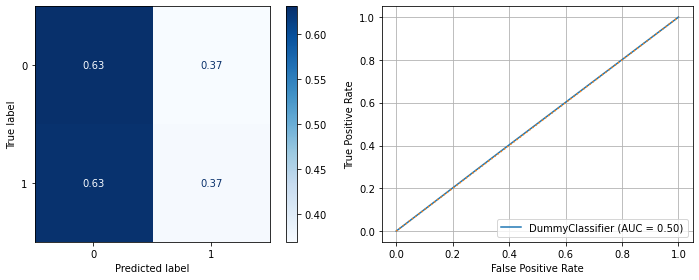

In [15]:
## Creating baseline classifier model

base = DummyClassifier(strategy='stratified', random_state = 42)

base.fit(X_train_tf_df, y_train)

clf.evaluate_classification(base,X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test, 
                           metric = 'balanced accuracy')

# -- > 🛑 **FIX**: Re-run all models w/ new data, kfold CV

# **Logistic Regression Model**

---

**Results:**

> Training balanced accuracy score: 0.82
> 
> Testing balanced accuracy score: 0.82
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.37
>
> Testing data log loss: 0.37

---

**Interpretation**

> 

---

In [16]:
## Speeding up SKLearn via Intel(R) Extension for Scikit-learn*
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [17]:
## LogReg Model

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter = 600,C = .1,solver = 'lbfgs',
                            n_jobs=-1,random_state = 42)

logreg.fit(X_train_tf_df, y_train)

LogisticRegression(C=0.1, max_iter=600, n_jobs=1, random_state=42)


|-------------------------------- Classification Metrics -----------------------------------|

Training balanced recall score: 0.81
Testing balanced recall score: 0.81
	- The scores are the same size.

Training data log loss: 0.35
Testing data log loss: 0.36



|---------------------------- Classification Report - Testing Data -------------------------|

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     18792
           1       0.82      0.71      0.76     11056

    accuracy                           0.83     29848
   macro avg       0.83      0.81      0.81     29848
weighted avg       0.83      0.83      0.83     29848



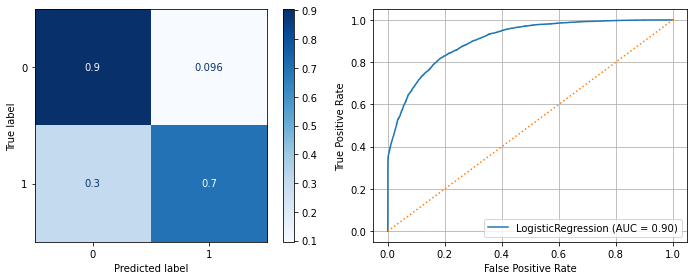


|---------------------------- Classification Report - Training Data ------------------------|

              precision    recall  f1-score   support

           0       0.84      0.91      0.87     56374
           1       0.82      0.71      0.76     33168

    accuracy                           0.83     89542
   macro avg       0.83      0.81      0.82     89542
weighted avg       0.83      0.83      0.83     89542



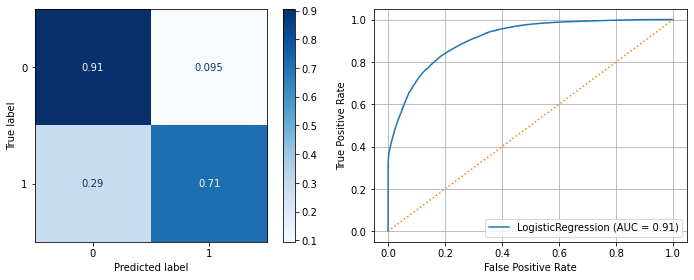

In [18]:
clf.evaluate_classification(logreg, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

In [19]:
## Collecting coefficients for each feature as a Series
lr_coefs = pd.Series(logreg.coef_.flatten(), index=X_train_tf_df.columns)
lr_coefs.sort_values(ascending=False, inplace=True)
lr_coefs

deposit_type_Non Refund        2.48
agent_17                       2.19
previous_cancellations         1.88
agent_240                      1.87
country_PRT                    1.78
                               ... 
agent_152                     -0.89
assigned_room_type_I          -1.21
reserved_room_type_A          -1.41
required_car_parking_spaces   -1.70
deposit_type_No Deposit       -1.72
Length: 661, dtype: float64

In [20]:
log_odds = pd.concat([lr_coefs.head(5), lr_coefs.tail(5)])
log_odds

deposit_type_Non Refund        2.48
agent_17                       2.19
previous_cancellations         1.88
agent_240                      1.87
country_PRT                    1.78
agent_152                     -0.89
assigned_room_type_I          -1.21
reserved_room_type_A          -1.41
required_car_parking_spaces   -1.70
deposit_type_No Deposit       -1.72
dtype: float64

In [21]:
new_labels_list = [i.replace('_', ' ').title() for i in list(log_odds.index)]
new_labels_list

['Deposit Type Non Refund',
 'Agent 17',
 'Previous Cancellations',
 'Agent 240',
 'Country Prt',
 'Agent 152',
 'Assigned Room Type I',
 'Reserved Room Type A',
 'Required Car Parking Spaces',
 'Deposit Type No Deposit']

In [22]:
new_labels_dict = { k:v for (k,v) in zip(log_odds.index, new_labels_list)}
new_labels_dict

{'deposit_type_Non Refund': 'Deposit Type Non Refund',
 'agent_17': 'Agent 17',
 'previous_cancellations': 'Previous Cancellations',
 'agent_240': 'Agent 240',
 'country_PRT': 'Country Prt',
 'agent_152': 'Agent 152',
 'assigned_room_type_I': 'Assigned Room Type I',
 'reserved_room_type_A': 'Reserved Room Type A',
 'required_car_parking_spaces': 'Required Car Parking Spaces',
 'deposit_type_No Deposit': 'Deposit Type No Deposit'}

In [23]:
log_odds = log_odds.rename(new_labels_dict)
log_odds.sort_values(inplace=True)

log_odds

Deposit Type No Deposit       -1.72
Required Car Parking Spaces   -1.70
Reserved Room Type A          -1.41
Assigned Room Type I          -1.21
Agent 152                     -0.89
Country Prt                    1.78
Agent 240                      1.87
Previous Cancellations         1.88
Agent 17                       2.19
Deposit Type Non Refund        2.48
dtype: float64

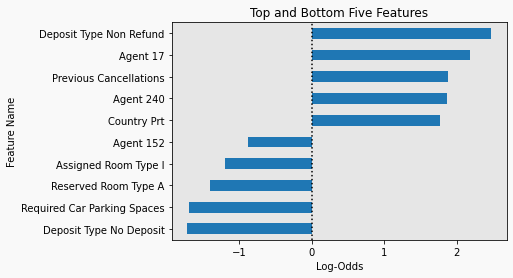

In [24]:
fig, ax = plt.subplots()

ax = log_odds.plot(kind='barh', ax=ax)
ax.axvline(linestyle = ':', c='k')
ax.set_xlabel('Log-Odds')
ax.set_ylabel('Feature Name')
ax.set_title('Top and Bottom Five Features')
ax.set_facecolor('0.9')
fig.set_facecolor('0.975')
# plt.tight_layout();
plt.savefig('./img/log_odds_test.png',transparent=False, bbox_inches='tight')

In [ ]:
## Converting from Log-Odds to Probabilities

## From log-odds to odds
lr_coefs = np.exp(lr_coefs)

lr_coefs.sort_values(ascending=False)

In [ ]:
## From odds to probabilities
lr_coefs = lr_coefs/(1+lr_coefs)

lr_coefs.sort_values(ascending=False)

---

***May the (Log-)Odds be Ever in Your Favor***

> Based on the logistic regression model coefficients, I see that reservations are **most likely to cancel** if they:
* Have a large lead time
* Stay mostly during the weekend
* Have previous cancellations
* Guests are from Portugal ([PRT is the three letter ISO 3166-1 code for Portugal](https://en.wikipedia.org/wiki/Portugal#:~:text=ISO%203166%20code,PT))
>
> Alternatively, reservations are **least likely to cancel** if they are:
* Bookings that do not require a deposit
* Requiring parking spaces
* Reserve room type "A"
* Are assigned to room type "I"
* Are booked by agent 152

**Increasingly Intuitive Interpretation**

> The numerical coefficients are in units of log-odds, as mentioned previously. I will perform some simple conversions to turn them into probabilities that are more understandable.

---

# LogisticRegressionCV

---

>

---

In [ ]:
# ## LogRegCV Model

# from sklearn.linear_model import LogisticRegressionCV

# logregcv = LogisticRegressionCV(cv = 3, max_iter = 750,random_state = 42)

# logregcv.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(logregcv, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

In [ ]:
# logregcv.C_

In [ ]:
# logregcv.coef_.shape

In [ ]:
# lrcoef_series = pd.Series(logregcv.coef_.flatten(), index=X_train_tf_df.columns)
# lrcoef_series

In [ ]:
# lrcoef_series.sort_values()

In [ ]:
# data['deposit_type'].value_counts()

In [ ]:
# sns.countplot(data = data, hue='deposit_type', x=target)

In [ ]:
# data.loc[:,['is_canceled', 'reservation_status']]

In [ ]:
# data.nunique()

---

> Above cells show exploration of results and trying to understand why particular agents are such strong coefficients

---

# **SMOTENC**

final_cols = [*num_cols, *ohe_cat_names]

In [ ]:
# smote_feats = [False]*len(num_cols) +[True]*len(ohe_cat_names)
# smote_feats

In [ ]:
# smote_nc = SMOTENC(categorical_features=smote_feats, random_state=42)
# X_resampled, y_resampled = smote_nc.fit_resample(X_train_tf_df, y_train)

# **Random Forest Model**

---

**Results:**

> Training balanced recall score: 0.99
> 
> Testing balanced recall score: 0.88
>
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.08
>
> Testing data log loss: 0.27

---

**Interpretation**

> 

---

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(class_weight = 'balanced', n_jobs=-1,
                             random_state=42)

rfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(rfc, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

In [ ]:
clf.plot_importances(rfc, X_train_tf_df)

# **AdaBoost Model**

---

**Results:**

> Training balanced recall score: 0.82
>
> Testing balanced recall score: 0.81
>
> * *The training score is larger by 0.01 points.*
>
> Training data log loss: 0.68
>
> Testing data log loss: 0.68

---

**Interpretation**

> 

---

In [ ]:
# abc = AdaBoostClassifier(n_estimators=100, random_state=42)

# abc.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(abc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **Gradient Boosting Model**

---

**Results:**

> Training score: 0.81
> 
> Testing score: 0.80
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.4
>
> Testing data log loss: 0.4

---

**Interpretation**

> 

---

In [ ]:
# gbc = GradientBoostingClassifier(n_iter_no_change  = 5, random_state=42)

# gbc.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(gbc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **ExtraTreesClassifier**

---

**Results:**

> Training balanced recall score: 1.0
> 
> Testing balanced recall score: 0.87
> 
> * 
>
> Training data log loss: 0.01
>
> Testing data log loss: 0.33

---

**Interpretation**

> 

---

In [ ]:
# etc = ExtraTreesClassifier(class_weight = 'balanced', n_jobs=-1, random_state=42)

# etc.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(etc, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# **XGBoost Classifier**

---

**Results:**

> Training balanced accuracy score: 0.86
> 
> Testing balanced accuracy score: 0.86
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.24
>
> Testing data log loss: 0.26

---

**Interpretation**

> 

---

In [ ]:
# xbgc = XGBClassifier(n_jobs = 4, random_state=42)
# xbgc.fit(X = X_train_tf_df, y=y_train)

In [ ]:
# clf.evaluate_classification(xbgc,X_train_tf_df, y_train, X_test_tf_df, y_test,
#                             metric= 'balanced accuracy')

# **GridSearchCV Results**

# -- > 🛑 **FIX**: Rerun w/ KFCV, new data

## **GridSearchCV - Logistic Regression**

---

**Results:**

> *Results unavailable - did not run model due to time required*

---

**Interpretation**

> 

---

In [ ]:
# lr_params = {
#  'C': [.001, .01, .1, 1],
#     'penalty':['l1', 'l2'],#, 'elasticnet', 'none'],
#     'solver':['newton-cg', 'liblinear', 'sag', 'saga', 'lbfgs'],
#     'max_iter':[100, 300, 500]}

# gscv = GridSearchCV(LogisticRegression(class_weight='balanced'), lr_params,
#                     scoring = 'balanced_accuracy', cv=3, n_jobs = -1)
# gscv

# gscv.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(gscv.best_estimator_, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced accuracy')

In [ ]:
# logreg_params = gscv.best_params_

# logreg_params

In [ ]:
# gscv.best_estimator_

## **GSCV - RandomForest**

---

**Scores**

> Training balanced accuracy score: 0.99
> 
> Testing balanced accuracy score: 0.88
> 
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.10
>
> Testing data log loss: 0.26

---

**Best Parameters**

> 'criterion': 'entropy'
> 
> 'max_depth': None
> 
> 'min_samples_leaf': 2
> 
> 'min_samples_split': 2

**Interpretation**

> 

---

In [ ]:
# rfc_params = {
#     'criterion': ['gini', 'entropy'],
#     'max_depth': [25,50, None],
#     'min_samples_split': [2,3,4],
#     'min_samples_leaf': [1,2]
# }

In [ ]:
# rfgs = GridSearchCV(RandomForestClassifier(class_weight = 'balanced',
#                                            random_state = 42, n_jobs=-1),
#                     rfc_params,scoring = 'balanced_accuracy',
#                     cv=3,verbose = 4)

# rfgs.fit(X_train_tf_df, y_train)

In [ ]:
# rfgs.best_params_

In [ ]:
# rfgs.best_score_

In [ ]:
# rfc_new = rfgs.best_estimator_

In [ ]:
# clf.evaluate_classification(rfc_new, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'balanced recall')

# Balanced Bagging Classifier

---

**MODEL: BalancedBaggingClassifier**

**Scores**

> Training balanced accuracy score: 0.98
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.11 points.*
>
> Training data log loss: 0.11
>
> Testing data log loss: 0.30

---

**Interpretation**

> 

---

In [ ]:
# ## Testing balanced bagging classifier
# from imblearn.ensemble import BalancedBaggingClassifier
# from sklearn.ensemble import GradientBoostingClassifier

# balanced_bagging = BalancedBaggingClassifier\
#                 (base_estimator=GradientBoostingClassifier(random_state=42),
#                  n_estimators=10, n_jobs=4, random_state=42)

# balanced_bagging.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(balanced_bagging, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

## GSCV: Balanced Bagging

---

**MODEL:** GridSearchCV - BalancedBaggingClassifier

**Scores**

> Training balanced accuracy score: 0.96
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.07 points.*
>
> Training data log loss: 0.20
>
> Testing data log loss: 0.30

---

**Best Parameters**

> 'base_estimator': RandomForestClassifier()
>
> 'replacement': 'True'
>
> 'sampling_strategy': 'majority'

**Interpretation**

> 

---

In [ ]:
# bal_bag_params = {'base_estimator': [RandomForestClassifier()],
#                   'replacement': ['True'],
#                   'sampling_strategy': ['majority', 'not minority',
#                                         'not majority', 'all']
#                  }

In [ ]:
# bbgs = GridSearchCV(BalancedBaggingClassifier(n_jobs=-1,random_state=42), 
#                     bal_bag_params, scoring = 'balanced_accuracy',
#                     cv=3, verbose = 4)

# bbgs.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(bbgs, X_train_tf_df, y_train, X_test_tf_df, 
#                            y_test, 'balanced accuracy')

In [ ]:
# bbgs_params = bbgs.best_params_

# bbgs_params

# Balanced Random Forest Classifier

---

**MODEL: BalancedRandomForestClassifier**

**Scores**

> Training balanced accuracy score: 0.97
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.8 points.*
>
> Training data log loss: 0.17
>
> Testing data log loss: 0.30

---

**Best Parameters**

> 

**Interpretation**

> 

---

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

balanced_forest = BalancedRandomForestClassifier(n_jobs = -1, random_state=42)

balanced_forest.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(balanced_forest, X_train = X_train_tf_df, y_train = y_train,
                           X_test = X_test_tf_df, y_test = y_test,
                          metric = 'balanced recall')

### GSCV: Balanced Random Forest Classifier

---

**MODEL:** GridSearchCV - BalancedBaggingClassifier

**Scores**

> Training balanced accuracy score: 0.96
> 
> Testing balanced accuracy score: 0.89
> 
> * *The training score is larger by 0.07 points.*
>
> Training data log loss: 0.20
>
> Testing data log loss: 0.30

---

**Best Parameters**

> * 'criterion': 'entropy'
>
> * 'max_features': None
>
> * 'min_samples_leaf': 1
>
> * 'min_samples_split': 2

**Interpretation**

> 

---

In [ ]:
brfc_params = {'criterion': ['gini', 'entropy'],
               'min_samples_split': [2, 3, 4],
               'min_samples_leaf': [1,2,3]
              }

In [ ]:
brfc = GridSearchCV(BalancedRandomForestClassifier(n_jobs=-1,random_state=42), 
                    brfc_params,scoring = 'balanced_accuracy',
                    cv=3,verbose = 4)

brfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(brfc, X_train_tf_df, y_train, X_test_tf_df, 
                           y_test, 'balanced precision')

In [ ]:
brfc_params = brfc.best_params_

brfc_params

In [ ]:
brfc.best_score_

In [ ]:
brfc_params = {'criterion': ['entropy'],
               'min_samples_split': [2],
               'min_samples_leaf': [1],
               'class_weight': ['balanced', 'balanced_subsample']
              }

In [ ]:
brfc = GridSearchCV(BalancedRandomForestClassifier(n_jobs=-1,random_state=42), 
                    brfc_params,scoring = 'balanced_accuracy',
                    cv=3,verbose = 4)

brfc.fit(X_train_tf_df, y_train)

In [ ]:
clf.evaluate_classification(brfc, X_train_tf_df, y_train, X_test_tf_df, 
                           y_test, 'balanced precision')

## EasyEnsembleClassifier

---

**MODEL: EasyEnsembleClassifier**

**Scores**

> Training balanced accuracy score: 0.86
> 
> Testing balanced accuracy score: 0.85
> 
> * *The training score is larger by 0.01 points.*
>
> Training data log loss: 0.64
>
> Testing data log loss: 0.64

---

**Interpretation**

> 

---

In [ ]:
# easy_ensemble = EasyEnsembleClassifier(n_jobs = -1, random_state=42)

# easy_ensemble.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(easy_ensemble, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

## RUSBoostClassifier

---

**MODEL: RUSBoostClassifier**

**Scores**

> Training balanced accuracy score: 0.85
> 
> Testing balanced accuracy score: 0.85
> 
> * *The scores are the same size.*
>
> Training data log loss: 0.64
>
> Testing data log loss: 0.64

---

**Interpretation**

> 

---

In [ ]:
# rus_boost = RUSBoostClassifier(n_estimators=200, algorithm='SAMME.R',
#                                random_state=42)

# rus_boost.fit(X_train_tf_df, y_train)

In [ ]:
# clf.evaluate_classification(rus_boost, X_train = X_train_tf_df, y_train = y_train,
#                            X_test = X_test_tf_df, y_test = y_test,
#                           metric = 'balanced recall')

# Interpretation

---

**Odd Features**

> Now that I completed my modeling steps, I will review the results of each model and determine my final recommendations.
>
> My main models are a standard logistic regression and a Balanced Random Forest classifier ("BRFC"). **Each model provides a different way of identifying which features are most impactful: logistic regressions provide "log-odds" and a Balanced Random Forest Classifier produces "feature importances."** Both will require some processing for easy interpretation.

**Log-Odds to Probabilities**

> Interpreting log-odds is more complicated than simply seeing the coefficient for a given feature and saying, "Feature X shows a 20% increase in likelihood!" **I will convert these log-odds units into probabilities that are easier to understand.**

**Feature Importances and SHAP**

> As I mentioned earlier, tree-based models, including my BRFC-model, return "feature importances" instead of the coefficients associated with linear/logistic regressions. These values are useful to show the impact of a given feature on the decision-making steps of the tree model. 
>
>However, these feature importances suffer from one key weakness: *they do not indicate if a feature increases or decreases the likelihood of a reservation canceling (my target feature).*
>
> I will utilize a visualization package called **SHAP** to produce "Shapely values" for each feature. These values indicate each feature's marginal contribution to the model - answering the question, "*How well does the model perform with this feature than without?*" 

**Seeing is Believing**

>Using tools within the package, I will focus on two visualizations:
> * The `summary_plot`: visualizing each feature's Shapely value and the feature's values from low-high (relative to each feature).
>
>
> * The `force_plot`: an in-depth look at the forces impacting any given reservation record.
>
> More information about SHAP:
* [SHAP Documentation](https://shap.readthedocs.io/en/latest/?badge=latest)
* [SHAP Repository](https://github.com/slundberg/shap)

---

## Log-Odds to Probabilities

---

**Conversions**

> To convert log-odds into probabilities, I will first convert them to odds via exponentiation, then convert the odds into probabilities via this formula:
$$probability = \frac {odds} {1 + odds}$$

---

In [ ]:
coeffs = pd.Series(model.coef_.flatten(), index=X_train.columns)
coeffs['intercept'] = model.intercept_[0]

if units=='odds':
    coeffs = np.exp(coeffs)

elif units=='prob':
    coeffs = np.exp(coeffs)
    coeffs = coeffs/(1+coeffs)

# MVP Notes

* CLF results - feature importances
* feature importances - visualize via SHAP


# Reviewing Results

---

> After testing several models, I found that MODELNAMEHERE produced the most accurate results.
>
> TOP 5 STRONGEST INDICATORS - Canceled Reservations:
> * 
> * 
> * 
>
> TOP 5 STRONGEST INDICATORS - Actualized Reservations:
> * 
> * 
> * 

---

# Recommendations

---

> Operationally, these results give us data-supported insights into our future guests and their needs. Once deployed, hotels would be able to use this model to forecast potential occupancy and staffing/supply needs. 
>
> Additionally, Operations teams would be able to determine how many and which guests would be the most likely to cancel their reservations. This information is very useful during periods of high-occupancy, particularly when trying to determine which guests to relocate in case of an oversold hotel.

---

# Future Work

---

> Time series modeling - forecasting based off of daily average probabilities (for a given # of arrivals, what is the forecast of %/# CXL?

> TSM - vector autoregressive forecasting using features to predict # cxl

> *Major stretch goal/future work:* determining likelihood of cancellations at given thresholds - e.g. 0-3, 4-7, 7-14, etc. days out
* What would be feature importances/coefficients at each threshold?
* Could I group the reservations based on their lead time despite different years?

---